In [1]:
from xgboost import XGBClassifier
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, matthews_corrcoef, confusion_matrix, recall_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
import statistics
import numpy as np
import pickle
import shap

In [2]:
df = pd.read_csv("data/17_selected_features_trainset.tsv", sep="\t")
df

,recount3_score,antisense_exon_start_ss,antisense_exon_end_ss,nearest_alt_start_ss_dist,nearest_alt_end_ss_dist,MaxEntScan_start_ss,MaxEntScan_end_ss,CpG_island,intron_length,phyloP_score,...,repeat_features_start_site_Satellite repeats,repeat_features_start_site_Type II Transposons,repeat_features_end_site_Tandem repeats,repeat_features_end_site_LTRs,repeat_features_end_site_Type I Transposons/SINE,repeat_features_end_site_Satellite repeats,repeat_features_end_site_Type I Transposons/LINE,splice_site,repeat_features_start_site_Type I Transposons/SINE,class
0,59151,False,False,170,362,9.09,11.90,False,385,5.65175,...,0,0,0,0,0,0,0,GT:AG,0,1
1,61021,False,False,24,232,7.66,3.89,False,499,1.40575,...,0,0,0,0,0,0,0,GT:AG,0,1
2,21,False,False,24,246,7.15,7.61,False,277,5.75650,...,0,0,0,0,0,0,0,GT:AG,0,1
3,526,False,False,322,232,1.14,3.89,False,168,5.35750,...,0,0,0,0,0,0,0,GC:AG,0,1
4,0,False,False,322,232,-12.10,7.63,False,78,3.62350,...,0,0,0,0,0,0,0,GT:AG,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484602,0,False,False,487,25,-19.72,3.66,True,909,0.58700,...,0,0,0,0,0,0,0,GT:AG,0,0
484603,31374,False,False,777,464,9.21,13.74,False,415,2.74250,...,0,0,0,0,0,0,0,GT:AG,0,0
484604,67,False,False,572,2963,8.56,2.38,False,2970,-0.89575,...,0,0,0,0,0,0,0,GT:AG,0,0
484605,18958,False,False,1178,2,-12.64,5.91,False,2358,2.41200,...,0,0,0,0,0,0,0,GT:AG,0,0


In [3]:
df.replace({True: 1, False: 0}, inplace=True)

In [4]:
ohe_splice_site = OneHotEncoder(sparse=False)
splice_site_reshaped = df['splice_site'].values.reshape(-1, 1)


onehot = ohe_splice_site.fit_transform(splice_site_reshaped)
df_onehot_ss = pd.DataFrame(onehot, columns=ohe_splice_site.get_feature_names_out(['splice_site']))
df = pd.concat([df, df_onehot_ss], axis=1)

with open("model/onehot_splice_site.pkl", "wb") as f:
    pickle.dump(ohe_splice_site, f)

df = df.drop(columns="splice_site")
df

,recount3_score,antisense_exon_start_ss,antisense_exon_end_ss,nearest_alt_start_ss_dist,nearest_alt_end_ss_dist,MaxEntScan_start_ss,MaxEntScan_end_ss,CpG_island,intron_length,phyloP_score,...,repeat_features_end_site_Tandem repeats,repeat_features_end_site_LTRs,repeat_features_end_site_Type I Transposons/SINE,repeat_features_end_site_Satellite repeats,repeat_features_end_site_Type I Transposons/LINE,repeat_features_start_site_Type I Transposons/SINE,class,splice_site_AT:AC,splice_site_GC:AG,splice_site_GT:AG
0,59151,0,0,170,362,9.09,11.90,0,385,5.65175,...,0,0,0,0,0,0,1,0.0,0.0,1.0
1,61021,0,0,24,232,7.66,3.89,0,499,1.40575,...,0,0,0,0,0,0,1,0.0,0.0,1.0
2,21,0,0,24,246,7.15,7.61,0,277,5.75650,...,0,0,0,0,0,0,1,0.0,0.0,1.0
3,526,0,0,322,232,1.14,3.89,0,168,5.35750,...,0,0,0,0,0,0,1,0.0,1.0,0.0
4,0,0,0,322,232,-12.10,7.63,0,78,3.62350,...,0,0,0,0,0,0,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484602,0,0,0,487,25,-19.72,3.66,1,909,0.58700,...,0,0,0,0,0,0,0,0.0,0.0,1.0
484603,31374,0,0,777,464,9.21,13.74,0,415,2.74250,...,0,0,0,0,0,0,0,0.0,0.0,1.0
484604,67,0,0,572,2963,8.56,2.38,0,2970,-0.89575,...,0,0,0,0,0,0,0,0.0,0.0,1.0
484605,18958,0,0,1178,2,-12.64,5.91,0,2358,2.41200,...,0,0,0,0,0,0,0,0.0,0.0,1.0


In [5]:
df_annot_test_y = df.pop("class")

In [6]:
X_train_val = df.copy()
y_train_val = df_annot_test_y.copy()

In [7]:
params =  {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

In [8]:
cv_acc_list = []
cv_ba_acc_list = []
cv_auroc_list = []
cv_precision_list = []
cv_recall_list = []
cv_mcc_list = []
cv_specificity_list = []
cv_sensitivity_list = []
cv_fpr_list = []
cv_fnr_list = []
model_dict = {}
model_index = 0
cv_predicted_labels = []
cv_true_labels = []
matrix = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf.get_n_splits(X_train_val, y_train_val)

for train_index, val_index in skf.split(X_train_val, y_train_val):
    X_train_resampled = X_train_val.iloc[train_index]
    y_train_resampled = y_train_val.iloc[train_index].to_numpy().flatten()

    X_train, X_val = X_train_resampled, X_train_val.iloc[val_index]
    y_train, y_val = y_train_resampled, y_train_val.iloc[val_index].to_numpy().flatten()

    model_dict[model_index] = XGBClassifier(random_state=2, tree_method="gpu_hist", scale_pos_weight=86761/397846, **params)  # 86761/397846 is the ration between negative data and positive data
    model_dict[model_index].fit(X_train, y_train)

    y_predict = model_dict[model_index].predict_proba(X_val)[:, 1]

    y_predict_class = model_dict[model_index].predict(X_val)
    cv_predicted_labels += list(y_predict)
    cv_true_labels += list(y_val)


    test_acc = accuracy_score(y_val, y_predict_class)
    test_auroc = roc_auc_score(y_val, y_predict)
    test_bal_acc = balanced_accuracy_score(y_val, y_predict_class)
    test_precision = precision_score(y_val, y_predict_class)  # tp/(tp+fp)
    test_recall = recall_score(y_val, y_predict_class)
    test_mcc = matthews_corrcoef(y_val, y_predict_class)
    matrix.append(confusion_matrix(y_val, y_predict_class))
    tn, fp, fn, tp = confusion_matrix(y_val, y_predict_class).ravel()

    # Adding the metrics to their list
    cv_acc_list.append(test_acc)
    cv_ba_acc_list.append(test_bal_acc)
    cv_auroc_list.append(test_auroc)
    cv_precision_list.append(test_precision)
    cv_mcc_list.append(test_mcc)
    cv_recall_list.append(test_recall)
    cv_specificity_list.append(tn / (tn + fp))
    cv_sensitivity_list.append(tp / (fn + tp))
    cv_fpr_list.append(fp/(fp+tn))
    cv_fnr_list.append(fn/(fn+tp))
    model_index += 1

In [9]:
print("------------------------------------------------------------------------------------------")
print("Stratified Cross-Validation Performance (* metrics of interest)")
print("------------------------------------------------------------------------------------------")
print("Accuracy: %s \n*AUCROC: %s \n*MCC: %s \nSensitivity: %s \nSpecificity: %s \n*Precision: %s \nRecall: %s \n*False Positive Rate: %s \nFalse Negative Rate: %s \n*Balanced Accuracy: %s" % (
        statistics.mean(cv_acc_list), statistics.mean(cv_auroc_list), statistics.mean(cv_mcc_list),
        statistics.mean(cv_sensitivity_list), statistics.mean(cv_specificity_list), statistics.mean(cv_precision_list), statistics.mean(cv_recall_list), statistics.mean(cv_fpr_list), statistics.mean(cv_fnr_list), statistics.mean(cv_ba_acc_list)))

print("------------------------------------------------------------------------------------------")
print("Accuracy SD: %s \n*AUCROC SD: %s \n*MCC SD: %s \nSensitivity SD: %s \nSpecificity SD: %s \n*Precision SD: %s  \nRecall SD: %s \n*False Positive Rate SD: %s \nFalse Negative Rate SD: %s \n*Balanced Accuracy SD: %s" % (
        np.std(cv_acc_list), np.std(cv_auroc_list), np.std(cv_mcc_list),
        np.std(cv_sensitivity_list), np.std(cv_specificity_list), np.std(cv_precision_list), np.std(cv_recall_list), np.std(cv_fpr_list), np.std(cv_fnr_list), np.std(cv_ba_acc_list)))

print("------------------------------------------------------------------------------------------")

sum(matrix)

------------------------------------------------------------------------------------------
Stratified Cross-Validation Performance (* metrics of interest)
------------------------------------------------------------------------------------------
Accuracy: 0.9489421323968762 
*AUCROC: 0.9797202696269903 
*MCC: 0.8361522086253972 
Sensitivity: 0.95580198940813 
Specificity: 0.9174860057534338 
*Precision: 0.9815216857877554 
Recall: 0.95580198940813 
*False Positive Rate: 0.08251399424656622 
False Negative Rate: 0.04419801059186997 
*Balanced Accuracy: 0.9366439975807819
------------------------------------------------------------------------------------------
Accuracy SD: 0.0006793429003685767 
*AUCROC SD: 0.0008520005335819716 
*MCC SD: 0.0021005388108620883 
Sensitivity SD: 0.0007238989695954489 
Specificity SD: 0.0022825970300467875 
*Precision SD: 0.0005006051939530123  
Recall SD: 0.0007238989695954489 
*False Positive Rate SD: 0.0022825970300468096 
False Negative Rate SD: 0.0007

array([[ 79602,   7159],
       [ 17584, 380262]])

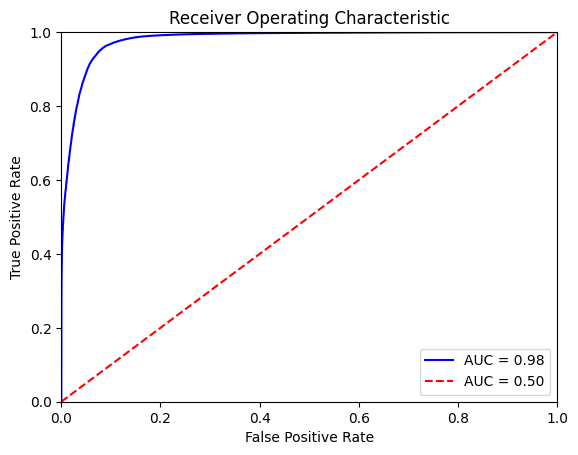

In [10]:
fpr, tpr, threshold = roc_curve(cv_true_labels, cv_predicted_labels)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="AUC = 0.50")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Construct ML model (high-recall mode) with all data

In [11]:
final_model = XGBClassifier(random_state=3, tree_method="gpu_hist", scale_pos_weight=86761/397846, **params)
final_model.fit(X_train_val[['recount3_score', 'antisense_exon_start_ss', 'antisense_exon_end_ss',
       'nearest_alt_start_ss_dist', 'nearest_alt_end_ss_dist',
       'MaxEntScan_start_ss', 'MaxEntScan_end_ss', 'CpG_island',
       'intron_length', 'phyloP_score', 'phastCons_score',
       'recount3_near_start_ss_with_better_score',
       'recount3_near_end_ss_with_better_score',
       'repeat_features_start_site_Tandem repeats',
       'repeat_features_start_site_LTRs',
       'repeat_features_start_site_Satellite repeats',
       'repeat_features_start_site_Type II Transposons',
       'repeat_features_end_site_Tandem repeats',
       'repeat_features_end_site_LTRs',
       'repeat_features_end_site_Type I Transposons/SINE',
       'repeat_features_end_site_Satellite repeats',
       'repeat_features_end_site_Type I Transposons/LINE',
       'repeat_features_start_site_Type I Transposons/SINE',
       'splice_site_AT:AC', 'splice_site_GC:AG', 'splice_site_GT:AG']], y_train_val)

# Save the model into pkl
pickle.dump(final_model, open("model/model_high_recall.pkl", "wb"))

# SHapley Additive exPlanations (SHAP) / Feature Importance Analysis

In [12]:
X_train_sample = X_train_val.sample(frac=0.5, random_state=4)
explainer = shap.TreeExplainer(final_model, X_train_val)

In [13]:
pickle.dump(explainer, open("model/shapExplainer_high_recall.pkl", "wb"))

In [14]:
shap_values = explainer(X_train_sample)

100%|===================| 242205/242304 [21:52<00:00]        

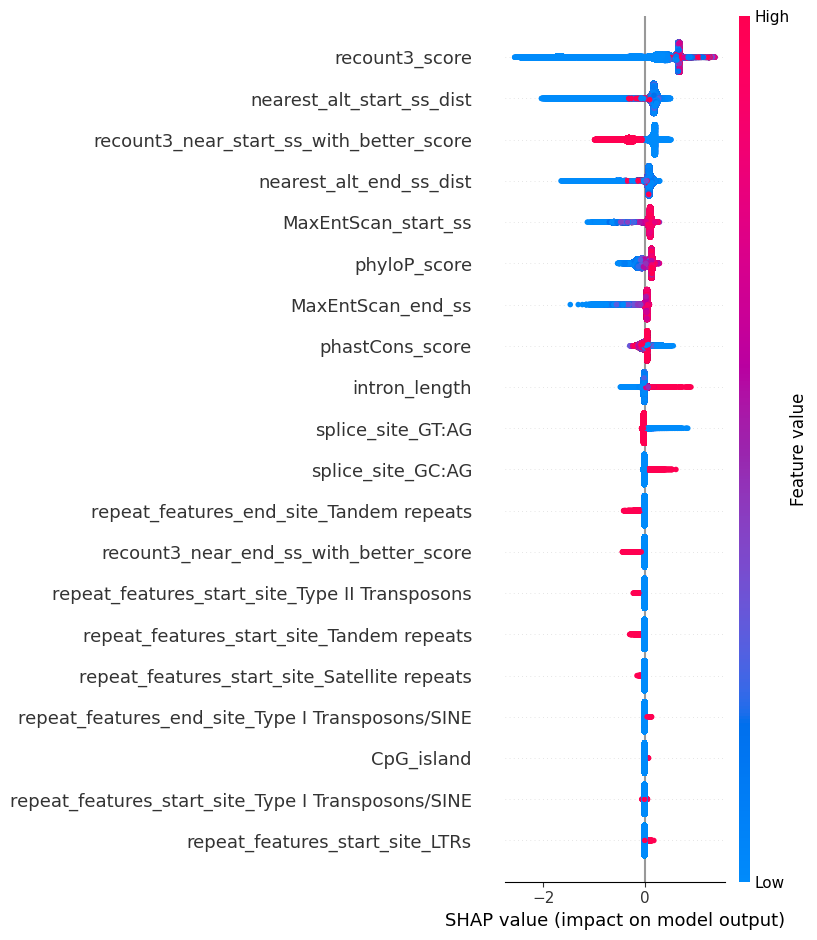

In [15]:
shap.summary_plot(shap_values[:,:], X_train_sample)

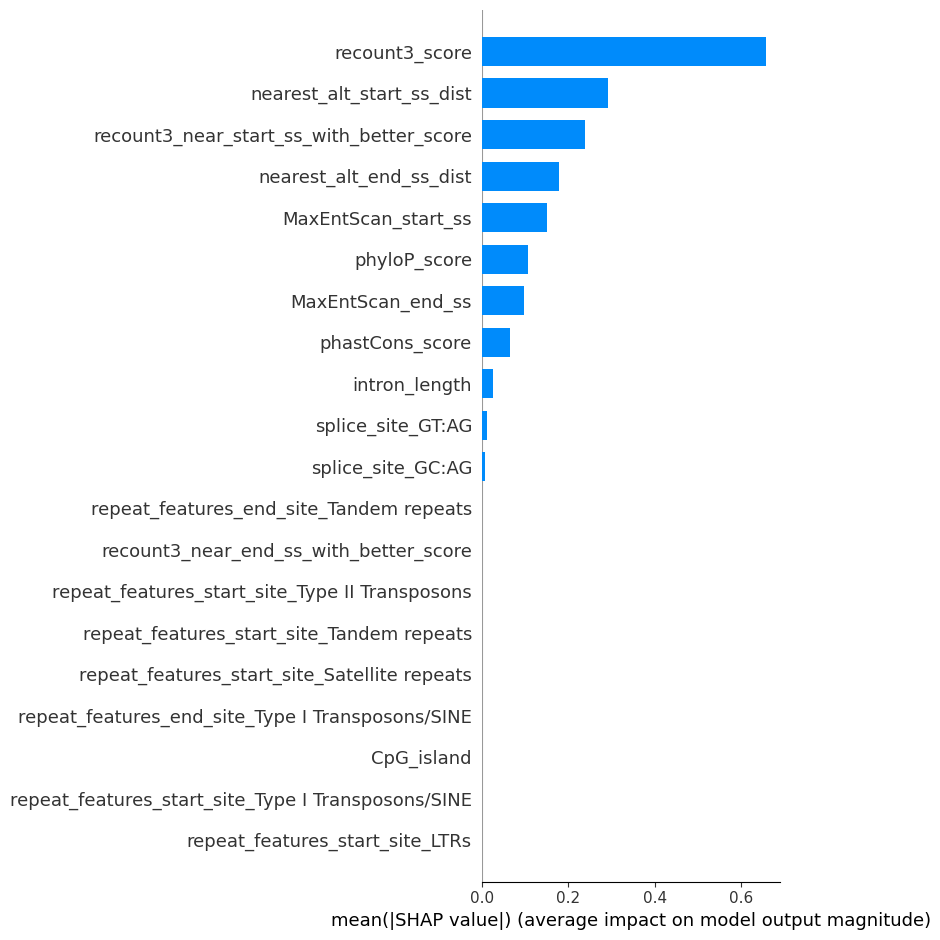

In [16]:
shap.summary_plot(shap_values[:,:], X_train_sample, plot_type="bar")